In [350]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [351]:
data_folder = 'ORL3232'

In [352]:
# 初始化空的資料和標籤列表
images = []
labels = []

for i in range(1, 41):  
    for j in range(1, 11):
        img_path = os.path.join(data_folder, str(i), f'{j}.bmp')
        img = Image.open(img_path).convert('L')  # 轉換為灰階圖像
        img = img.resize((32, 32))  # 確保圖像大小一致
        img_array = np.array(img).flatten()  # 轉換為一維陣列
        images.append(img_array)
        labels.append(i)

# 將資料和標籤轉換為NumPy陣列
images = np.array(images)
labels = np.array(labels)

# 查看資料和標籤的形狀
images.shape, labels.shape

((400, 1024), (400,))

In [353]:
# 切分訓練數據和測試數據
train_indices = []
test_indices = []

for i in range(40):
    base_index = i * 10
    train_indices.extend([base_index, base_index + 2, base_index + 4, base_index + 6, base_index + 8])
    test_indices.extend([base_index + 1, base_index + 3, base_index + 5, base_index + 7, base_index + 9])

# 奇數作為train，偶數作為test
train_x = images[train_indices]
train_y = labels[train_indices]
test_x = images[test_indices]
test_y = labels[test_indices]

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((200, 1024), (200,), (200, 1024), (200,))

In [354]:
def pca(data, n_components):
    # 計算平均值並進行資料中心化
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    # 計算共變異數矩陣
    covariance_matrix = np.cov(centered_data, rowvar=False)
    # 計算共變異數矩陣的特徵值和特徵向量
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    # 選擇前 n_components 個特徵向量
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_index]
    selected_eigenvectors = sorted_eigenvectors[:, :n_components]
    # 將資料投影到新的特徵空間
    reduced_data = np.dot(centered_data, selected_eigenvectors)
    return reduced_data, mean, selected_eigenvectors

In [355]:
def maxmin_normalize(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data, min_val, max_val

In [356]:
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.w1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((1, hidden_size))
        self.w3 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.b3 = np.zeros((1, output_size))
        self.learning_rate = learning_rate

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        logp = - np.log(y_pred[range(n_samples), y_true])
        loss = np.sum(logp) / n_samples
        return loss

    def forward(self, X):
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = np.maximum(0, self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = np.maximum(0, self.z2)
        self.z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = self.softmax(self.z3)
        return self.a3

    def backward(self, X, y_true, y_pred):
        n_samples = X.shape[0]
        dz3 = y_pred
        dz3[range(n_samples), y_true] -= 1
        dz3 /= n_samples
        dw3 = np.dot(self.a2.T, dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)
        da2 = np.dot(dz3, self.w3.T)
        dz2 = da2 * (self.z2 > 0)
        dw2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = np.dot(dz2, self.w2.T)
        dz1 = da1 * (self.z1 > 0)
        dw1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)
        self.w1 -= self.learning_rate * dw1
        self.b1 -= self.learning_rate * db1
        self.w2 -= self.learning_rate * dw2
        self.b2 -= self.learning_rate * db2
        self.w3 -= self.learning_rate * dw3
        self.b3 -= self.learning_rate * db3

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.cross_entropy_loss(y, y_pred)
            self.backward(X, y, y_pred)
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss:.4f}')

    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)


In [357]:
def lda(data, labels, n_components):
    class_labels = np.unique(labels)
    mean_overall = np.mean(data, axis=0)
    S_w = np.zeros((data.shape[1], data.shape[1]))
    S_b = np.zeros((data.shape[1], data.shape[1]))
    
    for label in class_labels:
        data_class = data[labels == label]
        mean_class = np.mean(data_class, axis=0)
        S_w += np.dot((data_class - mean_class).T, (data_class - mean_class))
        n_class_samples = data_class.shape[0]
        mean_diff = (mean_class - mean_overall).reshape(-1, 1)
        S_b += n_class_samples * np.dot(mean_diff, mean_diff.T)
    
    S_w_inv = np.linalg.inv(S_w)
    eig_vals, eig_vecs = np.linalg.eig(np.dot(S_w_inv, S_b))
    sorted_index = np.argsort(np.abs(eig_vals))[::-1]
    sorted_eigenvectors = eig_vecs[:, sorted_index]
    selected_eigenvectors = sorted_eigenvectors[:, :n_components]
    reduced_data = np.dot(data, selected_eigenvectors)
    return reduced_data, selected_eigenvectors

In [358]:
def nearest_neighbor_classifier(train_data, train_labels, test_data):
    predictions = []
    for test_point in test_data:
        distances = np.linalg.norm(train_data - test_point, axis=1)
        nearest_neighbor_index = np.argmin(distances)
        predicted_label = train_labels[nearest_neighbor_index]
        predictions.append(predicted_label)
    return np.array(predictions)


In [359]:
def plot_clusters(data, labels, title):
    plt.figure(figsize=(5, 4))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o')
    # Adding a color bar to show the legend for classes
    cbar = plt.colorbar(scatter)
    cbar.set_label('Classes')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

In [360]:
def plot_classification_results(test_data, true_labels, predicted_labels):
    plt.figure(figsize=(5, 4))
    correct = (true_labels == predicted_labels)
    plt.scatter(test_data[correct, 0], test_data[correct, 1], c='g', label='Correct')
    plt.scatter(test_data[~correct, 0], test_data[~correct, 1], c='r', label='Incorrect')
    plt.legend()
    plt.title("Classification Results")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

1. PCA + MaxMin Normalization + Entropy based BackPropagation
( training data 共有 200 筆)
( testing data 共有 200 筆，正確率至少 85%以上 )

In [368]:
# 進行PCA降維
train_x_pca, mean, pca_eigenvectors = pca(train_x, n_components=65)
test_x_pca = np.dot(test_x - mean, pca_eigenvectors)

print(f'PCA reduced shape: {train_x_pca.shape}')

# 進行MaxMin Normalization
train_x_norm, min_val, max_val = maxmin_normalize(train_x_pca)
test_x_norm = (test_x_pca - min_val) / (max_val - min_val)

# 訓練基於熵的反向傳播神經網絡
nn = SimpleNN(input_size=65, hidden_size=100, output_size=40, learning_rate=0.1)
nn.train(train_x_norm, train_y - 1, epochs=300)

# 預測和計算準確率
train_predictions = nn.predict(train_x_norm)
test_predictions = nn.predict(test_x_norm)

train_accuracy = np.mean(train_predictions == (train_y - 1))
test_accuracy = np.mean(test_predictions == (test_y - 1))

#print(f'Train Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

PCA reduced shape: (200, 65)
Epoch [10/300], Loss: 3.6123
Epoch [20/300], Loss: 3.5028
Epoch [30/300], Loss: 3.4085
Epoch [40/300], Loss: 3.3132
Epoch [50/300], Loss: 3.2101
Epoch [60/300], Loss: 3.0992
Epoch [70/300], Loss: 2.9815
Epoch [80/300], Loss: 2.8545
Epoch [90/300], Loss: 2.7207
Epoch [100/300], Loss: 2.5783
Epoch [110/300], Loss: 2.4238
Epoch [120/300], Loss: 2.2605
Epoch [130/300], Loss: 2.0926
Epoch [140/300], Loss: 1.9219
Epoch [150/300], Loss: 1.7508
Epoch [160/300], Loss: 1.5850
Epoch [170/300], Loss: 1.4308
Epoch [180/300], Loss: 1.2971
Epoch [190/300], Loss: 1.1569
Epoch [200/300], Loss: 1.0032
Epoch [210/300], Loss: 0.8644
Epoch [220/300], Loss: 0.7471
Epoch [230/300], Loss: 0.6514
Epoch [240/300], Loss: 0.5710
Epoch [250/300], Loss: 0.5022
Epoch [260/300], Loss: 0.4433
Epoch [270/300], Loss: 0.3932
Epoch [280/300], Loss: 0.3505
Epoch [290/300], Loss: 0.3140
Epoch [300/300], Loss: 0.2827
Test Accuracy: 0.90


2. PCA + LDA + Neareast Neighbor Classifier
( training data 共有 200 筆 )
( testing data 共有 200 筆，正確率至少 90%以上 ，training data 會在 LDA 特徵空間被當作比對使用的 參考資料 ，以 nearest neighbor 方法比對 testing 與哪一個 training data 最近，就把該最近的 training data 的 label 判斷為此 testing data 的 label， 若相同的話即 correct， 若不同則為 incorrect ) 

In [367]:
# 進行PCA降維
train_x_pca, mean, pca_eigenvectors = pca(train_x, n_components=65)
test_x_pca = np.dot(test_x - mean, pca_eigenvectors)

for i in range(0, 21):
    # 進行LDA降維
    train_x_lda, lda_eigenvectors = lda(train_x_pca, train_y, n_components=i)
    test_x_lda = np.dot(test_x_pca, lda_eigenvectors)

    # 使用最近鄰分類器進行分類
    test_predictions_lda = nearest_neighbor_classifier(train_x_lda, train_y, test_x_lda)

    # 計算準確率
    test_accuracy_lda = np.mean(test_predictions_lda == test_y)
    print(f' {i}components Test Accuracy: {test_accuracy_lda:.2f}')

 0components Test Accuracy: 0.03
 1components Test Accuracy: 0.20
 2components Test Accuracy: 0.41
 3components Test Accuracy: 0.63
 4components Test Accuracy: 0.74
 5components Test Accuracy: 0.81
 6components Test Accuracy: 0.86
 7components Test Accuracy: 0.91
 8components Test Accuracy: 0.93
 9components Test Accuracy: 0.94
 10components Test Accuracy: 0.94
 11components Test Accuracy: 0.94
 12components Test Accuracy: 0.94
 13components Test Accuracy: 0.94
 14components Test Accuracy: 0.94
 15components Test Accuracy: 0.95
 16components Test Accuracy: 0.96
 17components Test Accuracy: 0.96
 18components Test Accuracy: 0.96
 19components Test Accuracy: 0.96
 20components Test Accuracy: 0.95


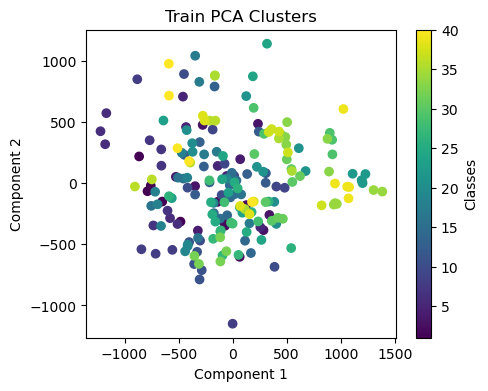

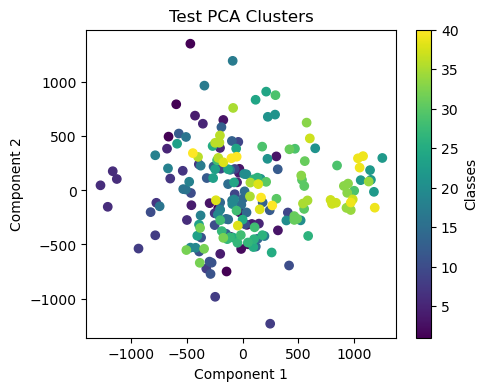

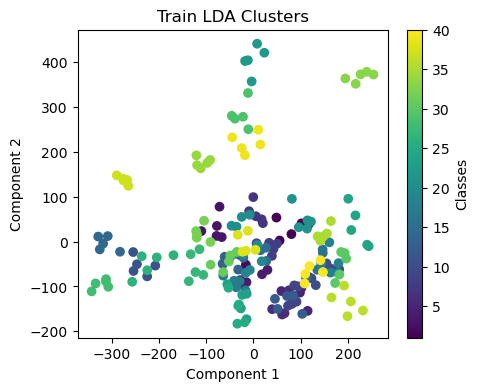

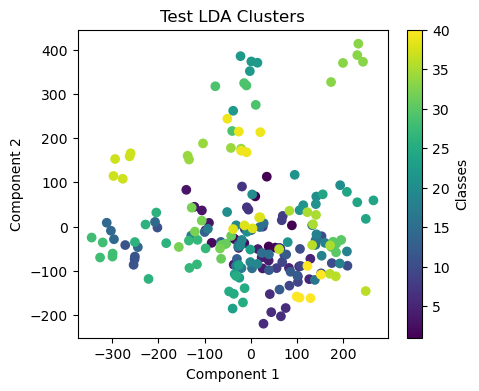

In [363]:
plot_clusters(train_x_pca, train_y, "Train PCA Clusters")
plot_clusters(test_x_pca, test_y, "Test PCA Clusters")
plot_clusters(train_x_lda, train_y, "Train LDA Clusters")
plot_clusters(test_x_lda, test_y, "Test LDA Clusters")

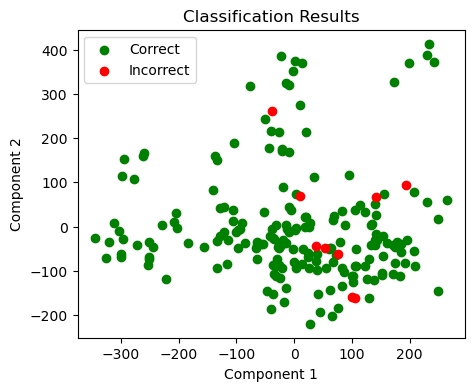

In [364]:
plot_classification_results(test_x_lda, test_y, test_predictions_lda)